# Basic optical ray tracing, the slow way
Francis Deck, 1-7-2023

I wrote this one first, to check my conceptual understanding of the equations. It runs very slowly -- 400 rays per second for a moderately complex model. My version using numpy is up to 35k rays per second, but is much harder to read.

Because this notebook is a dead end, the main route for fixing bugs is switching to one of the numpy based notebooks.

In [1]:
# %matplotlib notebook
from copy import copy, deepcopy

import matplotlib.pyplot as plt
import numpy as np

run_tests = True

## Math needs

In [2]:
def norm(x):
    # Length of vector x
    return np.sqrt(np.sum(x**2))


def radius(x):
    # distance of a point from the z axis
    return norm(x * np.array([1, 1, 0]))


def normalize(v):
    # Force a vector to be a unit vector
    return v / norm(v)

In [3]:
def sag_conic(R, c, k):
    """
    sag function for conic section surface
    R = distance from centerline
    c = curvature 1/ROC
    k = conic constant, 0 for sphere, -1 for parabola
    """
    return c * R**2 / (1 + np.sqrt(1 - (1 + k) * c**2 * R**2))


def d_sag_d_R2(R, c, k):
    """
    derivative of sag with respect to R^2, automatically generated by WxMaxima
    """
    R2 = R**2
    return (
        c / (np.sqrt(1 - R2 * c**2 * (k + 1)) + 1)
        + (
            (R2 * c**3 * (k + 1))
            / (
                np.sqrt(1 - R2 * c**2 * (k + 1))
                * (np.sqrt(1 - R2 * c**2 * (k + 1)) + 1) ** 2
            )
        )
        / 2
    )

### Distance from a point to a line

https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line

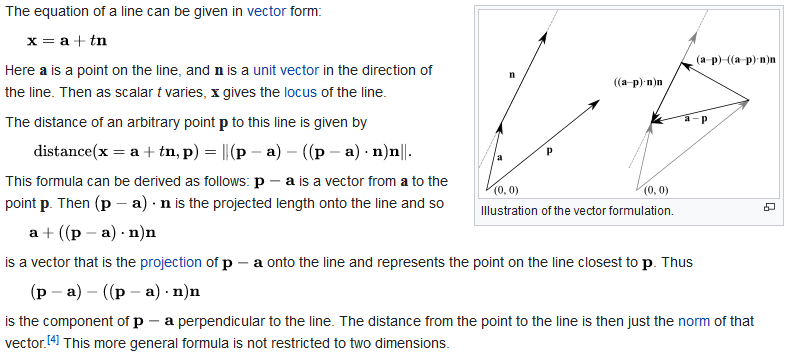

In [4]:
def distance_point_line(a, n, p):
    """
    distance from point to line
    a = point on the line
    n = unit vector in direction of line
    p = point in space
    """
    return norm(p - a - np.dot(p - a, n) * n)

### Intersection of a line and a plane

https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection

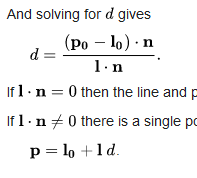 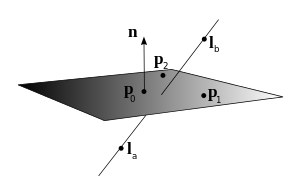

In [5]:
def intersect_line_plane(p0, n, l0, l):
    """
    intersection of line and plane
    p0 = point on plane
    n = normal to plane
    l0 = point on line
    l = direction vector of line
    """
    return l0 + l * np.dot((p0 - l0), n) / np.dot(l, n)

### Coordinate transformations

https://www.haroldserrano.com/blog/rotations-in-computer-graphics

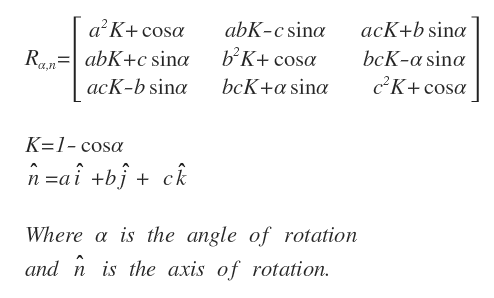

In [6]:
def rotate_matrix(axis, alpha_deg):
    alpha = alpha_deg * np.pi / 180
    a, b, c = axis
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    K = 1 - ca
    return np.matrix(
        [
            [a**2 * K + ca, a * b * K - c * sa, a * c * K + b * sa],
            [a * b * K + c * sa, b**2 * K + ca, b * c * K - a * sa],
            [a * c * K - b * sa, b * c * K + a * sa, c**2 * K + ca],
        ]
    )


def coord_rotate(v, axis, alpha_deg):
    M = rotate_matrix(axis, alpha_deg)
    return np.array(np.matmul(M, v))[0, :]


def coord_shift(x, dx):
    return x + dx


if run_tests:
    print(coord_rotate(np.array([0, 0, 1]), np.array([0, 1, 0]), 10))

[0.17364818 0.         0.98480775]


## Surfaces representation
    
We're going to start with surfaces. Currently, the following types are supported:

    {'surf': 'conic', 'c': curvature, 'k': conic_constant, 'n1': n1, 'n2': n2, 'dist': distance, ...}
    {'surf': 'dummy', 'dist': distance, ...}
    {'surf': 'shift', 'axis': vector, ...}
    {'surf': 'rotate', 'delta': vector, 'degrees': angle, ...}
    {'surf': 'plane grating', 'groove_width': w, 'wavelength': wl, 'dist': distance, ...}
    
These are the parameters that you specify for your model. A set of local coordinates will be added to each surface by the **build_geometry()** function. Also, the ellipses suggest that more parameters will be added, but I've included only those that are essential for understanding the math. The distance **dist** is the distance to the *next* surface along the local z-axis of each surface.

Surfaces will be combined to form a surface_list:

    surface_list: [surface, surface, ...]
    
Once the geometry has been built, each surface gains three new properties:

    {...'origin': point, 'x_axis': uvector, 'y_axis': uvector, 'z_axis: uvector ...}
    
This is a coordinate basis local to the surface, allowing plane and symmetrical surfaces to be defined with relatively few parameters. The local coordinates also guide the drawing of the surfaces.

**Units of measure**: Note that there are none. Everything is scalable to any unit system, so long as you're consistent. I'm going to be using mm. The only catch so far is that wavelengths are specified in mm, so a 633 nm laser is given as 633e-6

In [7]:
def apply_defaults(d, defaults):
    return d | {k: defaults[k] for k in defaults if k not in d}


def build_geometry(surface_list):
    geometry_defaults = {"dist": 0, "draw_radius": 10, "draw_dx": 0, "draw_dy": 0}
    # This is the coordinate basis that will be cumulatively updated
    # at each surface
    origin = np.array((0, 0, 0))
    x_axis = np.array((1, 0, 0))
    y_axis = np.array((0, 1, 0))
    z_axis = np.array((0, 0, 1))

    # Run through the surfaces, applying the coordinate basis to each
    # surface, while updating it for use by the next surface.
    geometry = []
    for s in surface_list:
        g = apply_defaults(s, geometry_defaults)
        if g["surf"] == "rotate":
            x_axis = coord_rotate(x_axis, g["axis"], g["degrees"])
            y_axis = coord_rotate(y_axis, g["axis"], g["degrees"])
            z_axis = coord_rotate(z_axis, g["axis"], g["degrees"])
        elif g["surf"] == "shift":
            origin = coord_shift(
                origin,
                g["delta"][0] * x_axis
                + g["delta"][1] * y_axis
                + g["delta"][2] * z_axis,
            )
        # Apply the new coordinates to the current surface
        g["origin"] = np.array(origin)
        g["x_axis"] = np.array(x_axis)
        g["y_axis"] = np.array(y_axis)
        g["z_axis"] = np.array(z_axis)
        # Set the origin of the next surface
        origin = origin + g["dist"] * z_axis
        geometry.append(g)
    return geometry

## Basic graphing
Remember, this isn't Zemax. The purpose of graphing is to aid in testing the programs by visualizing the output. I'm going to use them to check that my programs are functioning with no glaring errors.

If you want zoom-able graphs add **%matplotlib notebook** after importing **pyplot**. You may have to restart the kernel if you make this change. Notebook mode will gradually eat up your processing time because each graph spawns a Javascript process.

{'fig': <Figure size 432x288 with 2 Axes>, 'axs': array([<AxesSubplot:>, <AxesSubplot:>], dtype=object), 'x': 0, 'y': 1}


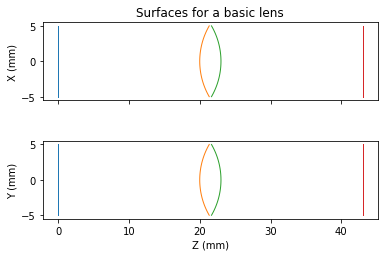

In [8]:
def new_plot_xy(axes=["x", "y"], **kwargs):
    # axes is an optional list of axes that you actually want to plot
    fig, axs = plt.subplots(len(axes), 1, sharex="col", sharey="row", **kwargs)
    # resolve fact that plt.subplots returns either a scalar axs or a list
    # depending on number of axes. We want always a list for consistency
    # later on.
    if len(axes) == 1:
        return {"fig": fig, "axs": [axs]} | {axes[i]: i for i in range(len(axes))}
    else:
        return {"fig": fig, "axs": axs} | {axes[i]: i for i in range(len(axes))}


def plot_faces(axd, surface_list):
    npts = 50
    x = np.empty((npts, 3))

    for s in surface_list:
        ra = np.linspace(-s["draw_radius"], s["draw_radius"], npts)
        xa = ra + s["draw_dx"]
        ya = ra + s["draw_dy"]

        # generate drawing curves in local coordinates of object
        match s["surf"]:
            case ("dummy" | "plane_grating" | "rotate" | "shift"):
                zxa = np.zeros_like(ra)
                zya = zxa
            case "conic":
                zxa = sag_conic(xa, s["c"], s["k"])
                zya = sag_conic(ya, s["c"], s["k"])

        # first graph shows the z-x coordinate axis in global space
        if "x" in axd:
            for i in range(npts):
                x[i, :] = s["origin"] + xa[i] * s["x_axis"] + zxa[i] * s["z_axis"]
            axd["axs"][axd["x"]].plot(x[:, 2], x[:, 0], linewidth=1)
            axd["axs"][axd["x"]].set_ylabel("X (mm)")

        # second graph shows the z-y coordinate axis in global space
        if "y" in axd:
            for i in range(npts):
                x[i, :] = s["origin"] + ya[i] * s["y_axis"] + zya[i] * s["z_axis"]
            axd["axs"][axd["y"]].plot(x[:, 2], x[:, 1], linewidth=1)
            axd["axs"][axd["y"]].set_ylabel("Y (mm)")
        axd["axs"][-1].set_xlabel("Z (mm)")

    [ax.set_aspect("equal") for ax in axd["axs"]]


def test():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3,
            "c": 1 / 10,
            "k": 0,
            "n1": 1,
            "n2": 1.5,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 20,
            "c": -1 / 10,
            "k": 0,
            "n1": 1.5,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 5, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)
    axd = new_plot_xy()
    print(axd)
    plot_faces(axd, geometry)
    axd["axs"][0].set_title("Surfaces for a basic lens")


if run_tests:
    test()

## Representing a ray

A ray is described by an intersection point and unit direction vector $(\vec x, \hat v)$ in *global* coordinates:

    Ray = {'x': np.array([x, y, z]), 'v': np.array([u, v, w]), 'option': ...}
    
A helper function creates rays from a pair of points $(\vec x, \vec p)$ by computing $\hat v = \dfrac {\vec p - \vec v} {|\vec p - \vec v|}:$

You can add more stuff to a ray, and it will be carried through the ray trace. One example is 'wavl' for wavelength.

In [9]:
def ray_from_points(x, p, **kwargs):
    return {"x": np.array(x), "v": normalize(p - x)} | kwargs


if run_tests:
    print(ray_from_points(np.array([0, 0, 0]), np.array([0, 0, 1]), wavl=633e-18))

{'x': array([0, 0, 0]), 'v': array([0., 0., 1.]), 'wavl': 6.33e-16}


## Propagation of ray to dummy surface

Dummy surface is a plane defined by the origin of the surface, and its z-axis.

In [10]:
def propagate_dummy(surface, ray):
    x1 = intersect_line_plane(surface["origin"], surface["z_axis"], ray["x"], ray["v"])
    return {"x": x1, "v": ray["v"]}

In [11]:
def plot_rays(axd, geometry, ray_lists, marker = "."):
    p = np.empty((3, len(geometry)))
    x = np.empty(len(geometry))
    y = np.empty(len(geometry))
    z = np.empty(len(geometry))
    keeps = []
    for i in range(len(geometry)):
        if geometry[i]["draw_radius"] != 0:
            keeps.append(i)
    for rayList in ray_lists:
        for i in range(len(rayList)):
            p[:, i] = rayList[i]["x"]
        if "x" in axd:
            axd["axs"][axd["x"]].plot(
                p[2][keeps], p[0][keeps], linewidth=1, marker=marker, markersize=2
            )
        if "y" in axd:
            axd["axs"][axd["y"]].plot(
                p[2][keeps], p[1][keeps], linewidth=1, marker=marker, markersize=2
            )

## Propagation of rays through refractive surface

I don't know who wrote this derivation, I found the image in a Google search, and it checks out.

https://image.slidesharecdn.com/raytracing-111026083006-phpapp01/95/ray-tracing-23-728.jpg

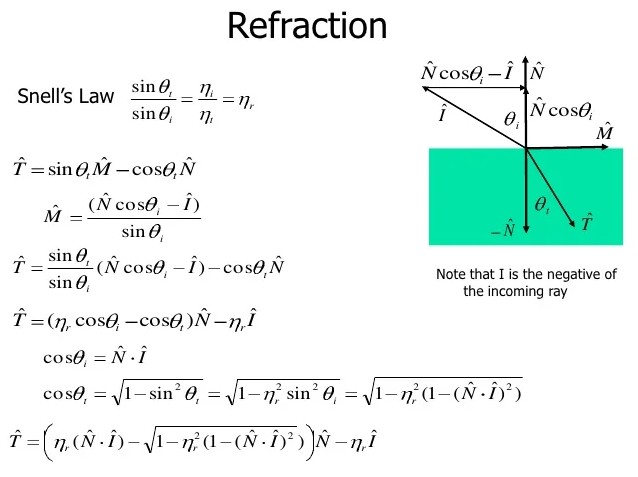

A second source at least is of known origin:

https://web.cse.ohio-state.edu/~shen.94/681/Site/Main.html

The slides on reflection and refraction are at: 

https://web.cse.ohio-state.edu/~shen.94/681/Site/Slides_files/reflection_refraction.pdf

The derivation sets up a coordinate basis $\hat M$ and $\hat N$, then composes the refracted ray $\hat T$ in terms of those coordinates.

How we trace the intersection to a conic surface:

Standard conic section sag equation (look up anywhere):

$z(r) = \dfrac {c r^2} {1 + \sqrt{1 - (1 + k)c^2r^2}}$

$r$ = distance from z axis

$c$ = curvature, i.e., reciprocal of radius-of-curvature

$k$ = conic constant, zero for sphere, -1 for parabola

Intersection of a ray with the surface is done iteratively:

1. Compute r and sag, trace ray to plane $z$ = sag
2. Re-compute r and sag, trace ray to new $z$ = sag
3. For now, good enough to just repeat this 10 times

For tracing through the interface by refraction, I followed the derivation in this slide. I don't know where this slide came from, so I'll copy the graphic here.

For rotationally symmetric function of $r^2$,

$\dfrac {\partial z(x, y)} {\partial x} = \dfrac {\partial z(r^2)}{\partial r^2} \dfrac {\partial r^2} {\partial x} =   2x\dfrac {\partial z(r^2)}{\partial r^2}$ ,likewise for $y$.

I computed $\dfrac {\partial z(r^2)}{\partial r^2}$ using wxMaxima. Later on I'd like to do this within the notebook using SymPy.

Here's the wxMaxima code for generating the derivative. WxMaxima doesn't produce Python output, but Fortran is easy enough to translate by hand:

    sag: c*R2/(1 + sqrt(1 - (1+k)*c^2*R2));
	fortran(diff(sag,R2,1));

In [12]:
def propagate_conic(surface, ray):
    # first step is intersecting the input ray with the curved surface
    sag = 0
    for i in range(10):
        xi = intersect_line_plane(
            surface["origin"] + sag * surface["z_axis"],
            surface["z_axis"],
            ray["x"],
            ray["v"],
        )
        r = distance_point_line(surface["origin"], surface["z_axis"], xi)
        sag = sag_conic(r, surface["c"], surface["k"])

    # second step is finding surface normal
    sd = d_sag_d_R2(r, surface["c"], surface["k"])
    x = np.dot(xi - surface["origin"], surface["x_axis"])
    y = np.dot(xi - surface["origin"], surface["y_axis"])
    n = normalize(
        2 * x * sd * surface["x_axis"]
        + 2 * y * sd * surface["y_axis"]
        - surface["z_axis"]
    )

    # third step is finding the direction of the refracted ray
    i = -ray["v"]
    ci = np.dot(i, n)
    eta = surface["n1"] / surface["n2"]
    ct = np.sqrt(1 - eta**2 * (1 - ci**2))
    vr = (eta * ci - ct) * n - eta * i
    return {"x": xi, "v": vr}

## Propagation of rays through diffraction grating

Grating. Equation 6.7 from here:

https://www.lambdares.com/wp-content/uploads/support/oslo/oslo_edu/oslo-optics-reference.pdf

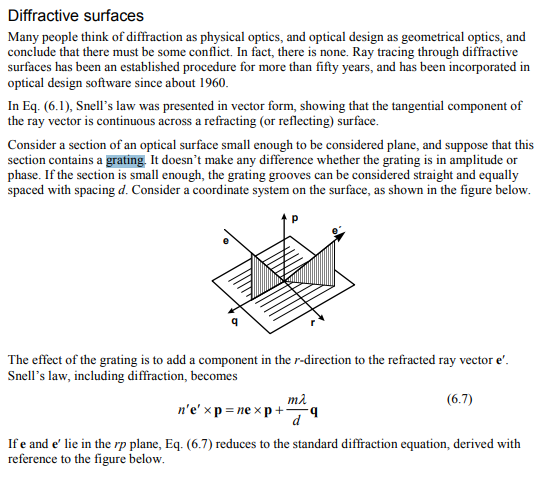

The grating equation as shown is completely general:

$n' \hat e' \times \hat p = n \hat e \times p + \dfrac {m \lambda} {d} \hat q$

However, for a plane grating, normal to the optical axis, and with grooves parallel to the x axis, it can be simplified by letting $\hat p = \hat k$ and $\hat q = \hat i$

Using the traditional formula for the cross product:

$\vec{a} \times \vec{b} = (a_2b_3-a_3b_2)i + (a_3b_1-a_1b_3)j+(a_1b_2-a_2b_1)k$

The general grating equation reduces to:

$n'(e'_y \hat x + e'_x \hat y) = n (e_y \hat x + e_x \hat y) + \dfrac {m \lambda} d \hat x$

Collecting like terms,

$e'_y = \dfrac 1 {n'}(n e_y + \dfrac {m \lambda)} d)$

$e'_x = \dfrac n {n'} e_x$

The simplification is acceptable because any other orientation of the grating can be handled with coordinate breaks.

As for concave gratings, my experience is that they are un-modelable. The reason is that concave holographic gratings tend to be quite specialized, and often have non-parallel grooves due to aberration corrections applied during the writing of the hologram. And the makers of these gratings can be reluctant to share their model data.

In [13]:
# grooves are oriented along x axis, use rotations as needed to choose a different axis


def propagate_plane_grating(surface, ray):
    x1 = intersect_line_plane(surface["origin"], surface["z_axis"], ray["x"], ray["v"])
    ey = (
        surface["n1"] * np.dot(ray["v"], surface["y_axis"])
        + surface["m"] * ray["wavl"] / surface["d"]
    ) / surface["n2"]
    ex = surface["n1"] * np.dot(ray["v"], surface["x_axis"]) / surface["n2"]
    ez = np.sqrt(1 - ex**2 - ey**2)
    r1 = {
        "x": x1,
        "v": ex * surface["x_axis"] + ey * surface["y_axis"] + ez * surface["z_axis"],
    }
    return r1

## Propagating rays through rotate and shift
*Nothing happens* to the rays through rotate and shift operations because rays are already expressed in global coordinates. Rotate and shift can be thought of as moving the optical system underneath the rays.

## Ray propagation through all surfaces
This function brings together all of the surface types under one roof, and builds a ray list -- a list of rays that propagate through the design, guided by the surface list.

It is necessarily an iterative process. The starting ray should typically be in the x-y plane, thus it represents an object point and direction vector. Based on the type of surface, a new ray is formed and appended to the list. However, the conic surface is special. The ray approaching a conic surface doesn't "know" the intersection point yet, so it doesn't know its destination, but has arrived at the x-y plane of the new surface. A *new ray* is computed that is extended to the intersection point, and this is what's appended to the ray list. This is why **propagate_conic** returns two rays -- a modified version of its incident ray, and a refracted ray.

All other surfaces (for now at least) are planar and don't need this treatment.

The last surface doesn't propagate rays any further. It only exists to be drawn.

In [14]:
def propagate_ray(first_ray, geometry):
    verbose = True
    current_ray = first_ray
    # Separate the non-geometric information so the individual propagation functions aren't burdened by it
    goodies = dict(first_ray)
    goodies.pop("x", None)
    goodies.pop("v", None)
    # Each propagate function returns a ray with intersection point at the current surface.
    ray_list = []
    for s in geometry:
        if s["surf"] in ["rotate", "shift", "dummy"]:
            current_ray = propagate_dummy(s, current_ray) | goodies
        elif s["surf"] == "conic":
            current_ray = propagate_conic(s, current_ray) | goodies
        elif s["surf"] == "plane grating":
            current_ray = propagate_plane_grating(s, current_ray) | goodies
        else:
            print("Did not recognize surface type", s["surf"])
        ray_list.append(current_ray)
    return ray_list

## Design process for now

To trace more than one ray through a system, it's convenient to build a list of ray lists. The graphing functions will use these lists. To summarize what we've got right now:

    ray: {'x': x, 'v': v}

    ray_list: [ray, ray...]

    ray_lists: [ray_list, ray_list...]

    surface: {'surf': surface_type, ...parameters..., 'origin': o, 'x_axis': i, 'y_axis': j, 'z_axis': k, 'drawRadius': r}
    
    surface_list: [surface, surface...]
    
A complete "design" for now is a rayLists and a surfList.

    design: ray_lists, surface_list
    
The design process looks like this:

1. Create a surfList from surfaces that have no geometry information (origin and axes) yet.
2. Use **build_geometry()** to add geometric information to the surfList. The surfList is modified by this process.
3. Create a list of starting rays that have object points and direction vectors, for instance using **ray_from_points** to specify points at an object surface and an entrance pupil. Right now I don't have a function for this, but simply build the list using Python list comprehensions. There's going to be more to this process later.
4. Apply **propagate_ray** to the list of starting rays, to build the rayLists. This concludes ray tracing.
5. Use the graphing routines to display your results!

## Testing

### Single ray through basic lens

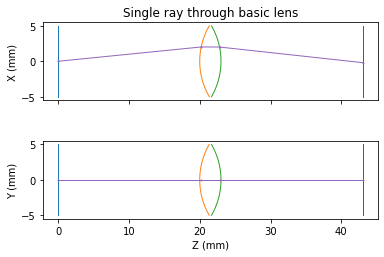

In [15]:
def test1():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3,
            "c": 1 / 10,
            "k": 0,
            "n1": 1,
            "n2": 1.5,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 20,
            "c": -1 / 10,
            "k": 0,
            "n1": 1.5,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)
    r0 = ray_from_points(np.array([0, 0, 0]), np.array([1, 0, 10]), wavl=633e-18)
    ray_list = propagate_ray(r0, geometry)
    ray_lists = [ray_list]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Single ray through basic lens")


if run_tests:
    test1()

### Singlet lens, finite conjugate

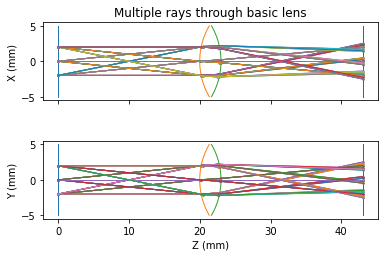

In [16]:
def test2():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3,
            "c": 1 / 10,
            "k": 0,
            "n1": 1,
            "n2": 1.5,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 20,
            "c": -1 / 10,
            "k": 0,
            "n1": 1.5,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    ls = np.linspace(-2, 2, 3)
    fieldPoints = [np.array([x, y, 0]) for x in ls for y in ls]
    pupilPoints = [np.array([x, y, 20]) for x in ls for y in ls]
    start_list = [ray_from_points(f, p) for f in fieldPoints for p in pupilPoints]

    ray_lists = [propagate_ray(s, geometry) for s in start_list]

    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Multiple rays through basic lens")


if run_tests:
    test2()

This is from *certain optics software*:
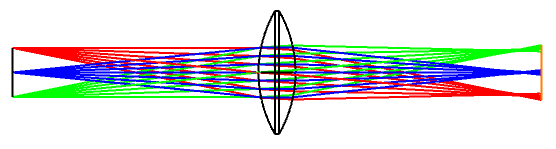

### Singlet lens, infinite conjugate

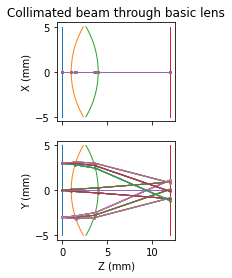

In [17]:
def test3():
    surface_list = [
        {"surf": "dummy", "dist": 1, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": 3.0,
            "c": 1 / 9.9,
            "k": 0,
            "n1": 1,
            "n2": 1.515,
            "draw_radius": 5,
        },
        {
            "surf": "conic",
            "dist": 8,
            "c": -1 / 9.9,
            "k": 0,
            "n1": 1.515,
            "n2": 1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-3, 3, 3)
    lsp = np.linspace(-0.1, 0.1, 3)
    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]
    ray_lists = [
        propagate_ray({"x": f, "v": p}, geometry)
        for f in field_points
        for p in pupil_points
    ]

    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Collimated beam through basic lens")


if run_tests:
    test3()

### Spherical mirror

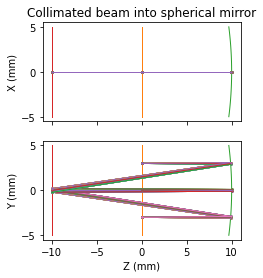

In [18]:
def test4():
    surface_list = [
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
        {"surf": "dummy", "dist": 10, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 40,
            "k": 0,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-3, 3, 3)
    lsp = np.linspace(-0.01, 0.01, 3)

    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]

    ray_lists = [
        propagate_ray({"x": f, "v": p}, geometry)
        for f in field_points
        for p in pupil_points
    ]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Collimated beam into spherical mirror")


if run_tests:
    test4()

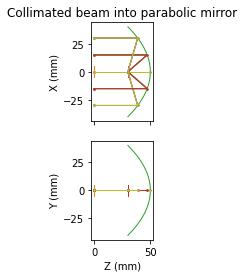

In [19]:
def test4():
    surface_list = [
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
        {"surf": "dummy", "dist": 50, "draw_radius": 5},
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 40,
            "k": -1,
            "n1": 1,
            "n2": -1,
            "draw_radius": 40,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-30, 30, 5)
    lsp = np.linspace(-0.01, 0.01, 5)

    field_points = [np.array([x, 0, 0]) for x in lsf]
    pupil_points = [normalize(np.array([0.0, 0, 1])) for x in lsp]

    ray_lists = [
        propagate_ray({"x": f, "v": p}, geometry)
        for f in field_points
        for p in pupil_points
    ]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Collimated beam into parabolic mirror")


if run_tests:
    test4()

### Diffraction grating

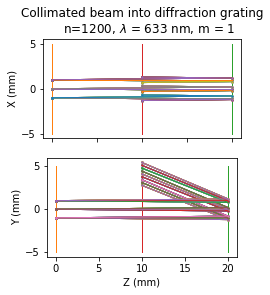

In [20]:
def test5():

    surface_list = [
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "plane grating",
            "dist": -10,
            "m": 1,
            "d": 1 / 600,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": -20, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    lsp = np.linspace(-0.01, 0.01, 3)
    field_points = [[x, y, 0] for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([x, y, 1])) for x in lsp for y in lsp]
    ray_lists = [
        propagate_ray({"x": f, "v": p, "wavl": 633e-6}, geometry)
        for f in field_points
        for p in pupil_points
    ]

    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title(
        """Collimated beam into diffraction grating
    n=1200, $\lambda$ = 633 nm, m = 1"""
    )


if run_tests:
    test5()

### Coordinate breaks

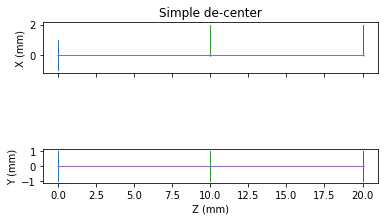

In [21]:
def test6():
    surface_list = [
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "shift", "delta": np.array((1, 0, 0)), "dist": 0, "draw_radius": 1},
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
    ]

    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    field_points = field_points = [np.array([0, 0, 0])]

    ray_lists = [
        propagate_ray({"x": f, "v": np.array([0, 0, 1])}, geometry)
        for f in field_points
    ]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Simple de-center")


if run_tests:
    test6()

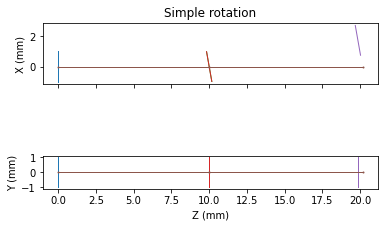

In [22]:
def test6():
    surface_list = [
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "dummy", "dist": 0, "draw_radius": 0},
        {
            "surf": "rotate",
            "axis": np.array((0, 1, 0)),
            "degrees": 10,
            "dist": 0,
            "draw_radius": 1,
        },
        {"surf": "dummy", "dist": 10, "draw_radius": 1},
        {"surf": "dummy", "dist": 0, "draw_radius": 1},
    ]

    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    field_points = [np.array([0, 0, 0])]

    ray_lists = [
        propagate_ray({"x": f, "v": np.array([0, 0, 1])}, geometry)
        for f in field_points
    ]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Simple rotation")


if run_tests:
    test6()

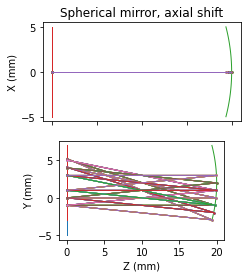

In [23]:
def test6():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {"surf": "shift", "delta": np.array([0, 2, 0]), "dist": 0, "draw_radius": 0},
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 20,
            "k": 0,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]
    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    lsp = np.linspace(-0.1, 0.1, 3)

    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]

    ray_lists = [
        propagate_ray({"x": f, "v": p}, geometry)
        for f in field_points
        for p in pupil_points
    ]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Spherical mirror, axial shift")


if run_tests:
    test6()

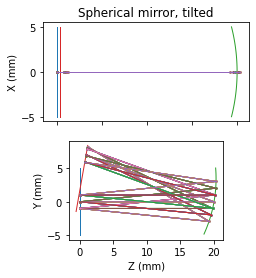

In [24]:
def test7():
    surface_list = [
        {"surf": "dummy", "dist": 20, "draw_radius": 5},
        {
            "surf": "rotate",
            "axis": np.array([1, 0, 0]),
            "degrees": 10,
            "dist": 0,
            "draw_radius": 0,
        },
        {
            "surf": "conic",
            "dist": -20,
            "c": -1 / 20,
            "k": 0,
            "n1": 1,
            "n2": -1,
            "draw_radius": 5,
        },
        {"surf": "dummy", "dist": 0, "draw_radius": 5},
    ]

    geometry = build_geometry(surface_list)

    lsf = np.linspace(-1, 1, 3)
    lsp = np.linspace(-0.1, 0.1, 3)

    field_points = [np.array([0.0, y, 0.0]) for x in lsf for y in lsf]
    pupil_points = [normalize(np.array([0.0, y, 1.0])) for x in lsp for y in lsp]

    ray_lists = [
        propagate_ray({"x": f, "v": p}, geometry)
        for f in field_points
        for p in pupil_points
    ]
    axd = new_plot_xy()
    plot_faces(axd, geometry)
    plot_rays(axd, geometry, ray_lists)
    axd["axs"][0].set_title("Spherical mirror, tilted")


if run_tests:
    test7()